# Phân loại văn bản báo tiếng việt

In [1]:
! pip install -U scikit-learn

  Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl.metadata (12 kB)
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.1-cp312-cp312-win_amd64.whl (10.9 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.5 MB 193.2 kB/s eta 0:03:50
   ----------------------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Phu Nguyen\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


## Import các thư viện cần dùng

In [1]:
import json
import requests
from pprint import pprint
import re
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import warnings
import sys
import torch

In [2]:
# Kiểm tra GPU có khả dụng không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise RuntimeError("No GPU found")

print(f'Using device: {device}')

Using device: cuda


In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device (GPU)
    device = torch.cuda.current_device()
    
    # Get total GPU memory
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)
    
    # Get allocated memory
    allocated_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)
    
    # Get cached memory
    cached_memory = torch.cuda.memory_reserved(device) / (1024 ** 3)
    
    print(f"Total GPU Memory: {total_memory:.2f} GB") # Tong dung luong GPU
    print(f"Allocated GPU Memory: {allocated_memory:.2f} GB") # Dung luong GPU da cap phat
    print(f"Cached GPU Memory: {cached_memory:.2f} GB") # Dung luong GPU da cache
else:
    print("CUDA is not available.")

Total GPU Memory: 6.00 GB
Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB


In [4]:
# Đặt random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

## Tiền sử lý dữ liệu

### Tải file json chứa dữ liệu

In [5]:
# URL trực tiếp đến file JSON thô trên GitHub
url = 'https://raw.githubusercontent.com/nmquang003/AI4E/main/10k_news.json'

# Tải nội dung của file
response = requests.get(url)

# Kiểm tra mã trạng thái phản hồi để đảm bảo rằng yêu cầu thành công
if response.status_code == 200:
    try:
        data = response.json()  # Đọc nội dung file JSON

        # Hiển thị phần tử đầu tiên của file JSON
        if isinstance(data, list) and len(data) > 0:
            pprint(json.dumps(data[0], indent=4, ensure_ascii=False))
        else:
            print("Dữ liệu JSON không phải là một danh sách hoặc danh sách trống.")

    except json.JSONDecodeError as e:
        print("JSONDecodeError: Không thể phân tích nội dung JSON.")
        print("Nội dung phản hồi không phải là JSON hợp lệ:")
        print(response.text)  # In ra nội dung phản hồi để kiểm tra
else:
    print(f"Yêu cầu thất bại với mã trạng thái {response.status_code}")
    print("Nội dung phản hồi:", response.text)

('{\n'
 '    "url": '
 '"https://vietnamnet.vn/dien-bien-to-chuc-hoi-nghi-tap-huan-cong-tac-nhan-quyen-nam-2023-2205811.html",\n'
 '    "title": "Điện Biên tổ chức Hội nghị tập huấn công tác nhân quyền năm '
 '2023",\n'
 '    "description": "Ngày 4/10, Ban Chỉ đạo Nhân quyền tỉnh Điện Biên phối '
 'hợp với Văn phòng Thường trực về Nhân quyền của Chính phủ tổ chức Hội nghị '
 'tập huấn công tác Nhân quyền trên địa bàn tỉnh năm 2023.",\n'
 '    "content": "Tại Hội nghị, các đại biểu đã được các báo cáo viên của Văn '
 'phòng Thường trực về nhân quyền, Ban Tôn giáo Trung ương trình bày các '
 'chuyên đề: “Công tác nhân quyền trong tình hình mới...”; “Đảm bảo quyền tự '
 'do tín ngường, tôn giáo...”.\\nCác báo cáo viên đã cung cấp nhiều thông tin '
 'mới về hoạt động lợi dụng dân tộc, tôn giáo, dân chủ, nhân quyền chống phá '
 'Việt Nam; thông tin về quyền con người và các quan điểm, chủ trương, chính '
 'sách bảo đảm quyền con người của Đảng, Nhà nước ta. Đồng thời, chia sẻ kinh '
 'nghiệ

### Xem các đầu mục

In [6]:
# Trích xuất các danh mục (categories)
categories = [article['metadata']['cat'] for article in data]

# Đếm số lượng từng danh mục
category_counts = {}
for category in categories:
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# In ra các danh mục và số lượng tương ứng
for category, count in category_counts.items():
    print(f"Category: {category}, Count: {count}")

Category: DÂN TỘC - TÔN GIÁO, Count: 164
Category: AN SINH, Count: 198
Category: TUẦN VIỆT NAM, Count: 203
Category: Ô TÔ - XE MÁY, Count: 383
Category: GIẢI TRÍ, Count: 399
Category: Xe, Count: 174
Category: NỘI DUNG CHUYÊN ĐỀ, Count: 184
Category: KHOA HỌC - CÔNG NGHỆ, Count: 177
Category: Pháp luật, Count: 211
Category: Đời sống, Count: 173
Category: PHÁP LUẬT, Count: 396
Category: DU LỊCH, Count: 395
Category: THÔNG TIN VÀ TRUYỀN THÔNG, Count: 181
Category: SỨC MẠNH SỐ, Count: 175
Category: Giải trí, Count: 208
Category: CHÍNH TRỊ, Count: 203
Category: BẠN ĐỌC, Count: 204
Category: LAO ĐỘNG - VIỆC LÀM, Count: 203
Category: KINH DOANH, Count: 510
Category: Bất động sản, Count: 200
Category: DÂN TỘC THIỂU SỐ VÀ MIỀN NÚI, Count: 182
Category: Du lịch, Count: 194
Category: SỨC KHỎE, Count: 406
Category: ĐỜI SỐNG, Count: 357
Category: Khoa học, Count: 177
Category: BẤT ĐỘNG SẢN, Count: 372
Category: THẾ GIỚI, Count: 367
Category: Kinh doanh, Count: 201
Category: Thế giới, Count: 201
Cat

### Chuyển đổi đầu mục

Filtered articles count: 7853


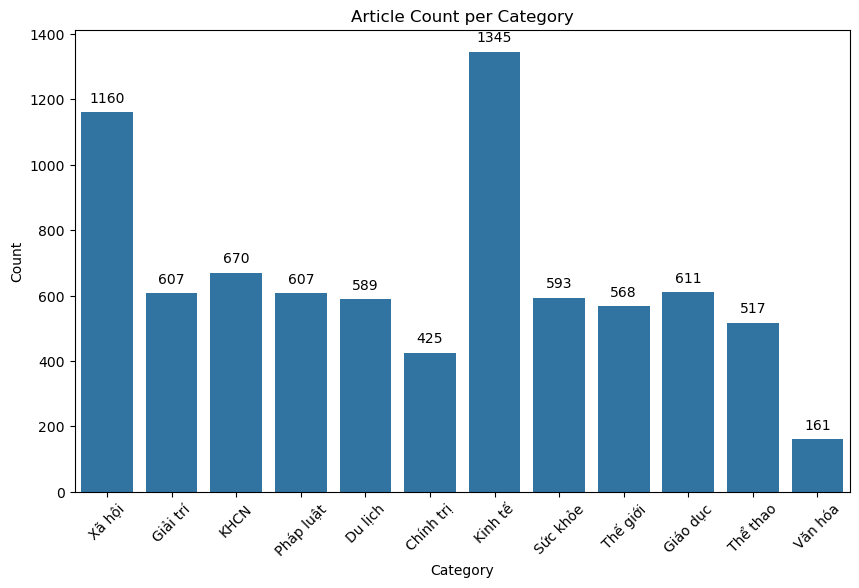

In [7]:
# Từ điển ánh xạ các categories hiện tại về 12 loại
category_mapping = {
    "CHÍNH TRỊ": "Chính trị",
    "THỜI SỰ": "Chính trị",
    "XÃ HỘI": "Xã hội",
    "ĐỜI SỐNG": "Xã hội",
    "AN SINH": "Xã hội",
    "LAO ĐỘNG - VIỆC LÀM": "Xã hội",
    "TÌNH YÊU - GIỚI TÍNH": "Xã hội",
    "KHOA HỌC - CÔNG NGHỆ": "KHCN",
    "SỨC MẠNH SỐ": "KHCN",
    "Số hóa": "KHCN",
    "CÔNG NGHIỆP HỖ TRỢ": "KHCN",
    "KINH DOANH": "Kinh tế",
    "Kinh doanh": "Kinh tế",
    "THỊ TRƯỜNG - TIÊU DÙNG": "Kinh tế",
    "BẤT ĐỘNG SẢN": "Kinh tế",
    "Bất động sản": "Kinh tế",
    "THẾ GIỚI": "Thế giới",
    "Thế giới": "Thế giới",
    "VĂN HÓA": "Văn hóa",
    "GIẢI TRÍ": "Giải trí",
    "Giải trí": "Giải trí",
    "DU LỊCH": "Du lịch",
    "Du lịch": "Du lịch",
    "GIÁO DỤC": "Giáo dục",
    "Giáo dục": "Giáo dục",
    "SỨC KHỎE": "Sức khỏe",
    "Sức khỏe": "Sức khỏe",
    "Các bệnh": "Sức khỏe",
    "PHÁP LUẬT": "Pháp luật",
    "Pháp luật": "Pháp luật",
    "THỂ THAO": "Thể thao",
    "Thể thao": "Thể thao"
}

# Lọc và chuyển đổi categories
filtered_data = []
for article in data:
    old_category = article['metadata']['cat']
    if old_category in category_mapping:
        new_category = category_mapping[old_category]
        article['metadata']['cat'] = new_category
        filtered_data.append(article)

# In ra các bài báo sau khi lọc và chuyển đổi categories
print(f"Filtered articles count: {len(filtered_data)}")

# Trích xuất các danh mục (categories)
categories = [article['metadata']['cat'] for article in filtered_data]

# Đếm số lượng từng danh mục
category_counts = {}
for category in categories:
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ nhỏ hơn
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45) # Xoay nhãn trục x để dễ đọc hơn

# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Filtered articles to use count: 4096


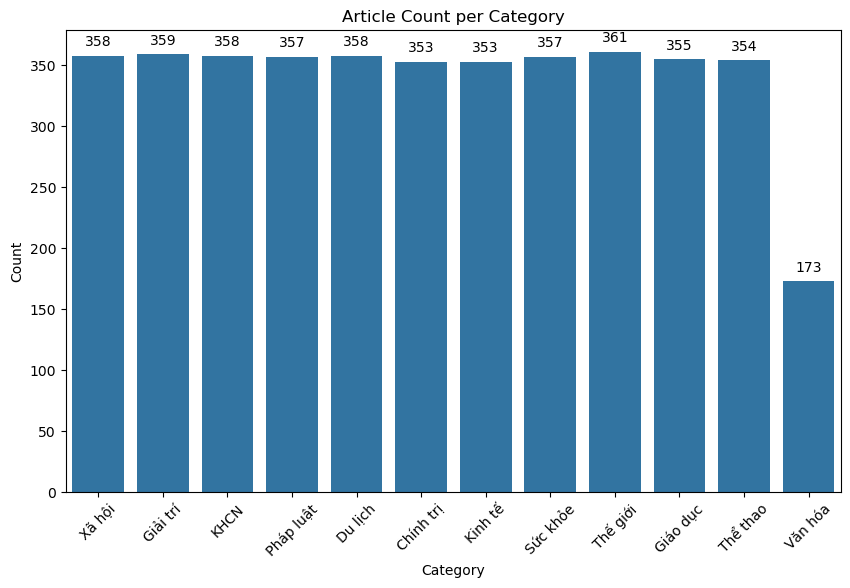

In [8]:
# Tạo một defaultdict để lưu các văn bản theo từng category
category_data = defaultdict(list)
for article in filtered_data:
    category_data[article['metadata']['cat']].append(article)

# Xác định số lượng mẫu tối đa cho mỗi category
number_sample = 4096
max_samples_per_category = number_sample // len(category_data)

# Chọn ngẫu nhiên các mẫu từ mỗi category, giới hạn bởi max_samples_per_category
balanced_data = []
for category, items in category_data.items():
    if len(items) > max_samples_per_category:
        balanced_data.extend(random.sample(items, max_samples_per_category))
    else:
        balanced_data.extend(items)

# Nếu số lượng mẫu không đủ number_sample, bổ sung thêm mẫu ngẫu nhiên từ balanced_data
if len(balanced_data) < number_sample:
    additional_samples = random.sample(balanced_data, number_sample - len(balanced_data))
    balanced_data.extend(additional_samples)

filtered_data_to_use = balanced_data[:number_sample if number_sample < len(balanced_data) else len(balanced_data)]
print(f"Filtered articles to use count: {len(filtered_data_to_use)}")

# Đếm số lượng từng danh mục
category_counts = defaultdict(int)
for item in filtered_data_to_use:
    category_counts[item['metadata']['cat']] += 1

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ nhỏ hơn
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### Làm sạch hơn dữ liệu

In [9]:
# Danh sách stop words tiếng Việt
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"
])

# Trích xuất dữ liệu từ các bài báo đã được lọc
texts = []
labels = []

# Lặp qua từng bài báo trong dữ liệu đã lọc
for article in filtered_data_to_use:
    # Kết hợp tiêu đề và nội dung bài báo
    text = article.get('title', '') + ' ' + article.get('content', '')
    # Lấy nhãn (category) của bài báo
    label = article['metadata']['cat']
    # Thêm văn bản và nhãn vào danh sách tương ứng
    texts.append(text)
    labels.append(label)

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    # Chuyển văn bản thành chữ thường
    text = text.lower()
    # Loại bỏ dấu câu
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # Tách văn bản thành các từ (tokens)
    tokens = text.split()
    # Đếm tổng số từ ban đầu
    total_tokens = len(tokens)
    # Loại bỏ các từ thuộc danh sách stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Tính phần trăm các từ stop words đã bị loại bỏ
    removed_stop_words_percent = (total_tokens - len(tokens)) / total_tokens * 100
    # Trả về văn bản đã được xử lý và phần trăm từ stop words đã bị loại bỏ
    return ' '.join(tokens), removed_stop_words_percent

# Danh sách chứa các văn bản đã qua tiền xử lý
processed_texts = []
# Danh sách chứa phần trăm các từ stop words đã bị loại bỏ trong từng văn bản
sum_stop_words_percents = 0

# Sử dụng tqdm để hiển thị thanh tiến trình khi xử lý các văn bản
tqdm_iter = tqdm(texts, desc="Processing texts")

# Lặp qua từng văn bản trong danh sách văn bản gốc
for i, text in enumerate(tqdm_iter):
    # Tiền xử lý văn bản và tính phần trăm từ stop words đã bị loại bỏ
    processed_text, stop_words_percent = preprocess_text(text)
    # Thêm văn bản đã qua tiền xử lý vào danh sách
    processed_texts.append(processed_text)
    # Thêm phần trăm từ stop words đã bị loại bỏ vào danh sách
    sum_stop_words_percents += stop_words_percent
    # Tính phần trăm trung bình của các từ stop words đã bị loại bỏ
    avg_stop_words_percent = sum_stop_words_percents / (i+1)
    # Cập nhật thanh tiến trình với phần trăm trung bình hiện tại
    tqdm_iter.set_postfix({"avg_stop_words_percent": f"{avg_stop_words_percent:.2f}%"})

# Cập nhật danh sách văn bản gốc với các văn bản đã qua tiền xử lý
texts = processed_texts
# Tính phần trăm trung bình cuối cùng của các từ stop words đã bị loại bỏ
average_stop_words_percent = sum_stop_words_percents / len(texts)

# In ra phần trăm trung bình của các từ stop words đã bị loại bỏ
print(f"Average percentage of stop words removed: {average_stop_words_percent:.2f}%")


Processing texts:   0%|          | 0/4096 [00:00<?, ?it/s]

Average percentage of stop words removed: 18.67%


In [10]:
print("Văn bản sau sử lý: ", texts[0])
print("Nhãn của văn bản: ", labels[0])

Văn bản sau sử lý:  chồng thể con mẹ anh muốn tôi ly hôn tôi phát quen nhau 3 năm cưới cuộc hôn nhân chúng tôi vô tốt đẹp bố mẹ chồng thương tôi coi con trong nhà tôi trong thâm tâm tôi thực yêu bố mẹ chồng bố mẹ mình sẵn sàng lý lắc mè nheo cuộc sống gia đình vô thoải mái một duy nhất khiến niềm vui chúng tôi trọn vẹn tin vui về đường con mặc dù hai vợ chồng tôi còn trẻ hoàn toàn khỏe mạnh hề đặt kế hoạch trì hoãn sinh con thấy tôi buồn mẹ chồng thường nói tìm cách an ủi mặc dù bà nói tôi thấy bà vô tinh tế liên tục mua đồ ăn quan điểm cụ thể giúp chúng tôi sớm con tôi biết mong muốn mẹ dù bà hề nói ý muốn thúc ép tôi thấy áp lực tôi bàn chồng đi khám chuyên khoa xem lý sao chúng tôi chậm em bé ít nhất biết lý đường hướng xử lý đỡ sốt ruột chờ đợi trong mông lung ngờ kết quả khám khiến hai chúng tôi bàng hoàng đỉnh điểm nỗi thất vọng tôi phát hiện phát ngoại tình ảnh minh họa adobe stock nguyên nhân khó con chồng tôi tinh trùng tôi bàn chồng tạm thời đừng nói bố mẹ tìm cách phát ôm tô

## Huấn luyện và đánh giá các mô hình truyền thống

### Tạo dữ liệu huấn luyện và kiểm thử cho các mô hình truyền thống

In [11]:
# Khai báo mảng label y
y = np.array(labels)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Nhãn gốc: ", y_train[:5])
print("Nhãn sau khi mã hóa: ", y_train_enc[:5])

# Shuffle the training data
texts_train, y_train_enc = shuffle(texts_train, y_train_enc, random_state=42)

# Vectorize texts using TF-IDF for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
X_test_tfidf = tfidf_vectorizer.transform(texts_test)

print("Kích thức của tập train: ", X_train_tfidf.shape)

Nhãn gốc:  ['KHCN' 'Xã hội' 'Xã hội' 'Chính trị' 'Kinh tế']
Nhãn sau khi mã hóa:  [ 4 11 11  0  5]
Kích thức của tập train:  (3276, 152)


### Khởi tạo, huấn luyện và đánh giá các mô hình truyền thống

Mô hình Naive Bayes

In [13]:
# Naive Bayes model
nb_model = MultinomialNB(alpha=1.0)

# Fit dữ liệu
nb_model.fit(X_train_tfidf, y_train_enc)

# Dự đoán
y_pred_enc_nb = nb_model.predict(X_test_tfidf)
y_pred_nb = le.inverse_transform(y_pred_enc_nb)

# Báo cáo phân loại cho Naive Bayes
report_nb = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)

In [13]:
print("Báo cáo phân loại cho Naive Bayes:")
print(classification_report(y_test, y_pred_nb, zero_division=0))

Báo cáo phân loại cho Naive Bayes:
              precision    recall  f1-score   support

   Chính trị       0.47      0.10      0.16        71
     Du lịch       0.78      0.29      0.42        72
    Giáo dục       0.84      0.73      0.78        71
    Giải trí       0.57      0.49      0.53        72
        KHCN       0.53      0.51      0.52        72
     Kinh tế       0.72      0.32      0.45        71
   Pháp luật       0.41      0.77      0.53        71
    Sức khỏe       0.50      0.77      0.61        71
    Thế giới       0.47      0.90      0.62        72
    Thể thao       0.73      0.72      0.72        71
     Văn hóa       0.00      0.00      0.00        34
      Xã hội       0.36      0.50      0.42        72

    accuracy                           0.53       820
   macro avg       0.53      0.51      0.48       820
weighted avg       0.55      0.53      0.50       820



Mô hình Logistic Regression

In [14]:
### YOUR START CODE HERE ###
# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000) # set max_iter=1000 để tránh cảnh báo về số lần lặp

# Fit dữ liệu
lr_model.fit(X_train_tfidf, y_train_enc)
# Dự đoán
y_pred_enc_lr = lr_model.predict(X_test_tfidf)
y_pred_lr = le.inverse_transform(y_pred_enc_lr)

# Báo cáo phân loại cho Logistic Regression
report_lr = classification_report(y_test, y_pred_lr, 
                                  output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

In [15]:
print("Báo cáo phân loại cho Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

Báo cáo phân loại cho Logistic Regression:
              precision    recall  f1-score   support

   Chính trị       0.53      0.32      0.40        71
     Du lịch       0.60      0.60      0.60        72
    Giáo dục       0.62      0.82      0.71        71
    Giải trí       0.51      0.46      0.48        72
        KHCN       0.49      0.46      0.47        72
     Kinh tế       0.63      0.48      0.54        71
   Pháp luật       0.49      0.63      0.56        71
    Sức khỏe       0.57      0.72      0.64        71
    Thế giới       0.64      0.72      0.68        72
    Thể thao       0.61      0.87      0.72        71
     Văn hóa       0.00      0.00      0.00        34
      Xã hội       0.46      0.40      0.43        72

    accuracy                           0.56       820
   macro avg       0.51      0.54      0.52       820
weighted avg       0.54      0.56      0.54       820



Mô hình Random Forest

In [15]:
### YOUR START CODE HERE ###
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit dữ liệu
rf_model.fit(X_train_tfidf, y_train_enc)
# Dự đoán
y_pred_enc_rf = rf_model.predict(X_test_tfidf)
y_pred_rf = le.inverse_transform(y_pred_enc_rf)

# Báo cáo phân loại cho Logistic Regression
report_rf = classification_report(y_test, y_pred_rf, 
                                  output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

In [18]:
print("Báo cáo phân loại cho Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Báo cáo phân loại cho Random Forest:
              precision    recall  f1-score   support

   Chính trị       0.60      0.66      0.63        71
     Du lịch       0.65      0.69      0.67        72
    Giáo dục       0.82      0.86      0.84        71
    Giải trí       0.60      0.69      0.65        72
        KHCN       0.60      0.67      0.63        72
     Kinh tế       0.66      0.55      0.60        71
   Pháp luật       0.69      0.79      0.74        71
    Sức khỏe       0.77      0.83      0.80        71
    Thế giới       0.79      0.88      0.83        72
    Thể thao       0.78      0.87      0.83        71
     Văn hóa       0.67      0.12      0.20        34
      Xã hội       0.65      0.42      0.51        72

    accuracy                           0.69       820
   macro avg       0.69      0.67      0.66       820
weighted avg       0.69      0.69      0.68       820



Mô hình SVM

In [16]:
### YOUR START CODE HERE ###
# SVM model
svc_model = SVC()

# Fit dữ liệu
svc_model.fit(X_train_tfidf, y_train_enc)
# Dự đoán
y_pred_enc_svc = svc_model.predict(X_test_tfidf)
y_pred_svc = le.inverse_transform(y_pred_enc_svc)

# Báo cáo phân loại cho Logistic Regression
report_svc = classification_report(y_test, y_pred_svc,
                                   output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

In [20]:
print("Báo cáo phân loại cho SVM:")
print(classification_report(y_test, y_pred_svc, zero_division=0))

Báo cáo phân loại cho SVM:
              precision    recall  f1-score   support

   Chính trị       0.46      0.51      0.48        71
     Du lịch       0.56      0.60      0.58        72
    Giáo dục       0.85      0.72      0.78        71
    Giải trí       0.41      0.51      0.46        72
        KHCN       0.49      0.60      0.54        72
     Kinh tế       0.61      0.44      0.51        71
   Pháp luật       0.54      0.66      0.59        71
    Sức khỏe       0.73      0.72      0.72        71
    Thế giới       0.70      0.74      0.72        72
    Thể thao       0.78      0.82      0.80        71
     Văn hóa       0.00      0.00      0.00        34
      Xã hội       0.46      0.44      0.45        72

    accuracy                           0.59       820
   macro avg       0.55      0.56      0.55       820
weighted avg       0.57      0.59      0.58       820



### Vẽ biểu đồ


Naive Bayes Metrics:
Chính trị: Precision=0.47, Recall=0.10, F1-Score=0.16
Du lịch: Precision=0.78, Recall=0.29, F1-Score=0.42
Giáo dục: Precision=0.84, Recall=0.73, F1-Score=0.78
Giải trí: Precision=0.57, Recall=0.49, F1-Score=0.53
KHCN: Precision=0.53, Recall=0.51, F1-Score=0.52
Kinh tế: Precision=0.72, Recall=0.32, F1-Score=0.45
Pháp luật: Precision=0.41, Recall=0.77, F1-Score=0.53
Sức khỏe: Precision=0.50, Recall=0.77, F1-Score=0.61
Thế giới: Precision=0.47, Recall=0.90, F1-Score=0.62
Thể thao: Precision=0.73, Recall=0.72, F1-Score=0.72
Văn hóa: Precision=0.00, Recall=0.00, F1-Score=0.00
Xã hội: Precision=0.36, Recall=0.50, F1-Score=0.42
Overall Accuracy: 0.53

Logistic Regression Metrics:
Chính trị: Precision=0.53, Recall=0.32, F1-Score=0.40
Du lịch: Precision=0.60, Recall=0.60, F1-Score=0.60
Giáo dục: Precision=0.62, Recall=0.82, F1-Score=0.71
Giải trí: Precision=0.51, Recall=0.46, F1-Score=0.48
KHCN: Precision=0.49, Recall=0.46, F1-Score=0.47
Kinh tế: Precision=0.63, Recall=0.4

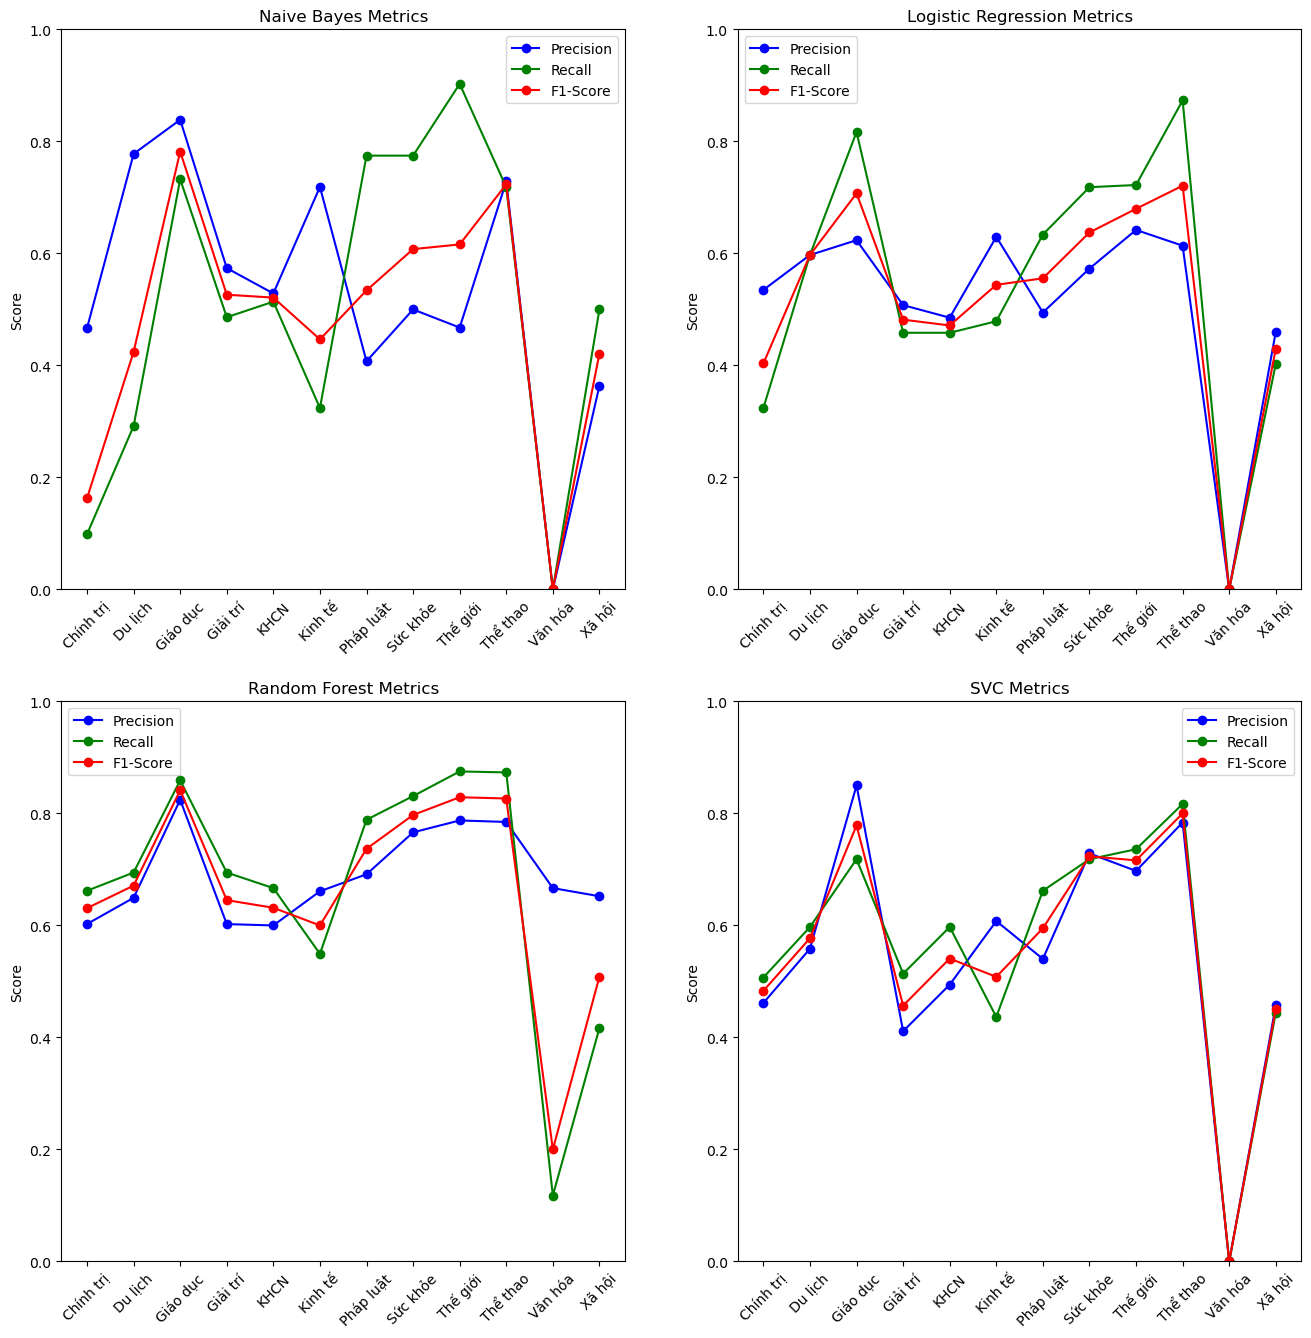

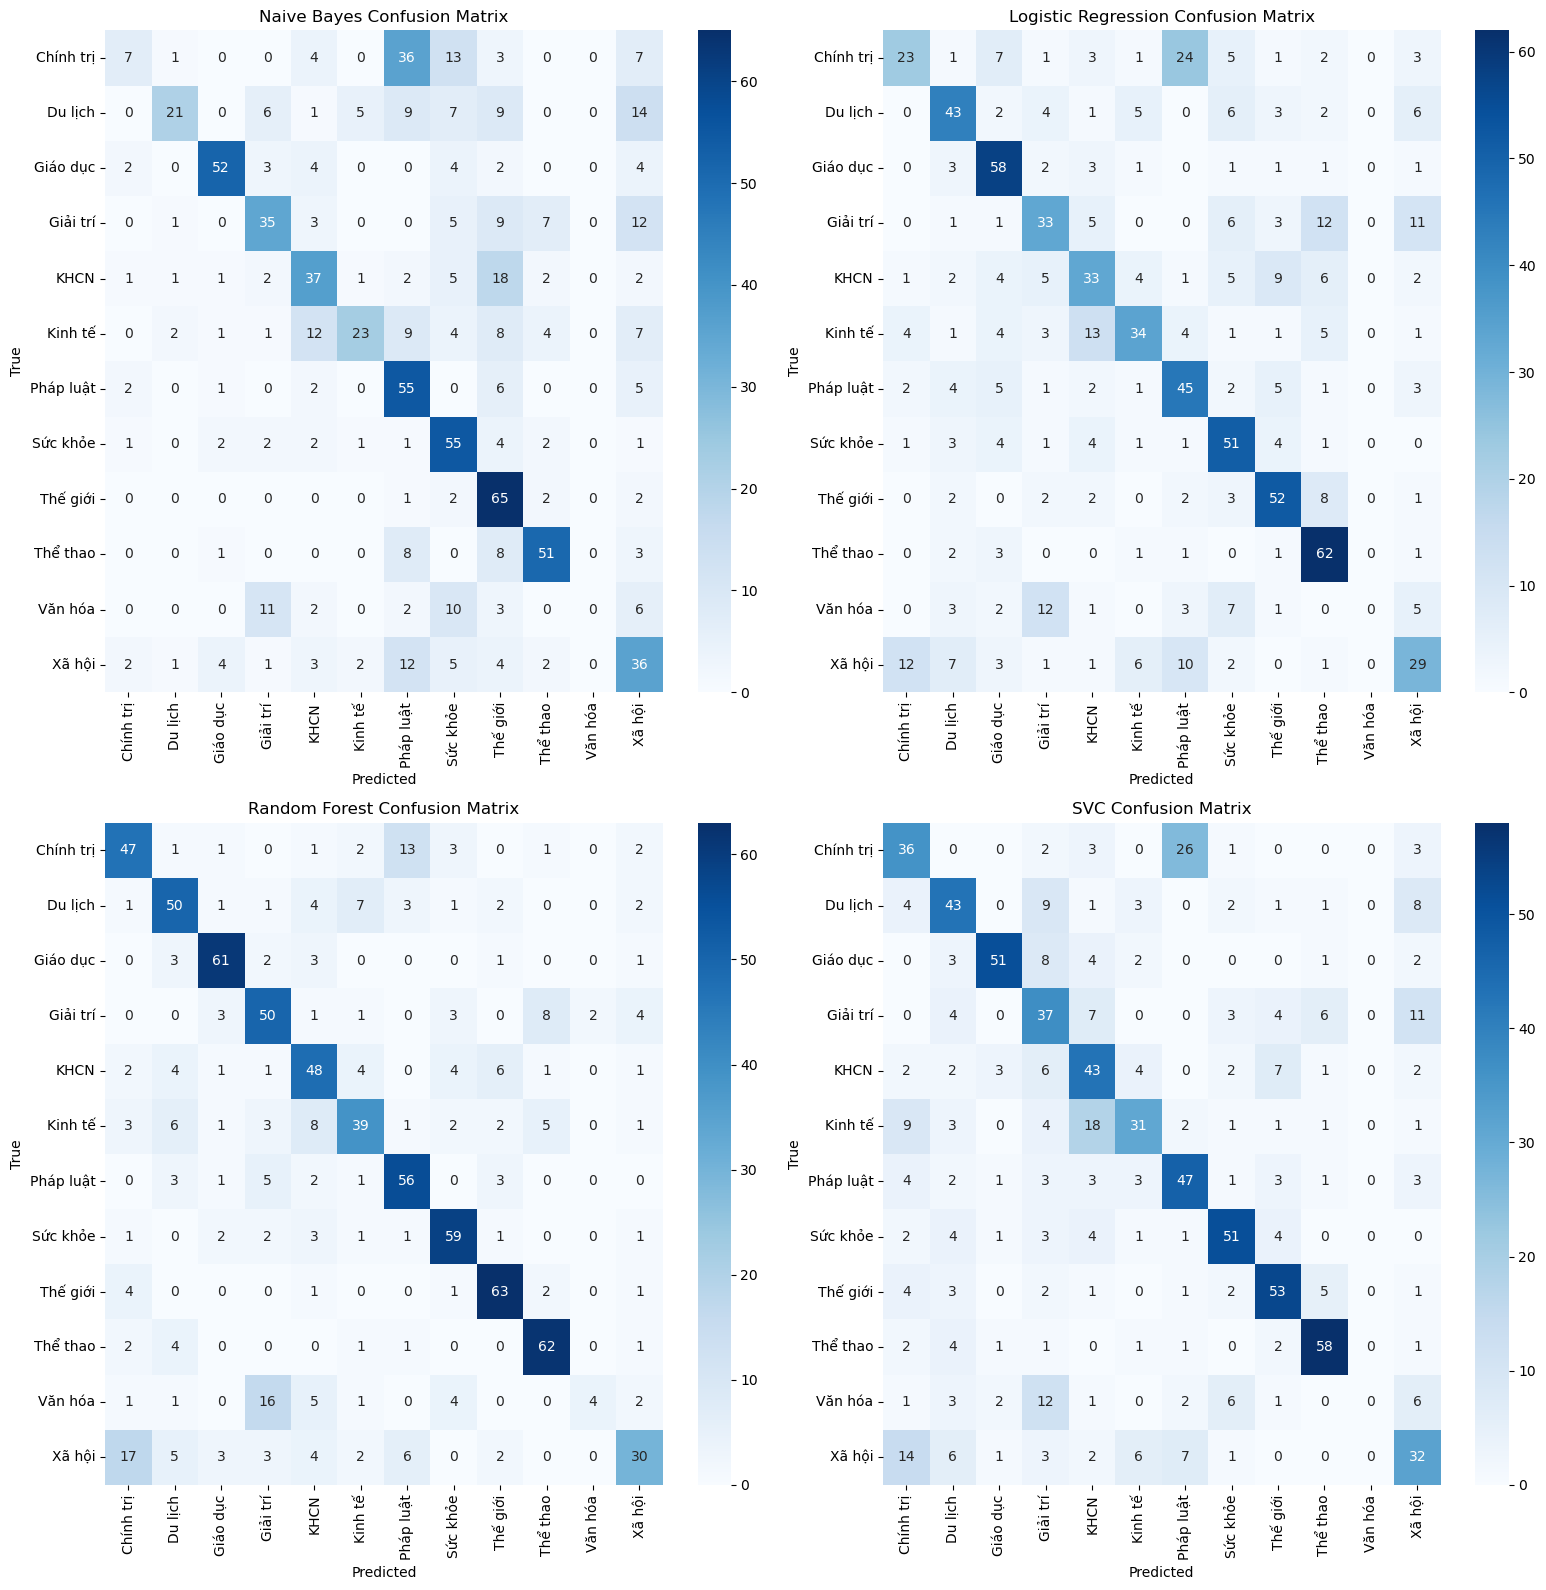

In [18]:
# Tạo danh sách các báo cáo phân loại
reports = {
    'Naive Bayes': report_nb,
    'Logistic Regression': report_lr,
    'Random Forest': report_rf,
    'SVC': report_svc
}

fig, axs = plt.subplots(2, 2, figsize=(16, 16)) # Tạo một grid 2x2 để chứa các biểu đồ
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16)) # Tạo một grid 2x2 để chứa các confusion matrix

for i, (name, report) in enumerate(reports.items()):
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}')

    # Vẽ biểu đồ đường
    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    if name == 'Naive Bayes':
        cm = confusion_matrix(y_test, y_pred_nb, labels=le.classes_)
    elif name == 'Logistic Regression':
        cm = confusion_matrix(y_test, y_pred_lr, labels=le.classes_)
    elif name == 'Random Forest':
        cm = confusion_matrix(y_test, y_pred_rf, labels=le.classes_)
    elif name == 'SVC':
        cm = confusion_matrix(y_test, y_pred_svc, labels=le.classes_)

    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [17]:
# In ra nhãn dự đoán và nhãn thực tế
print("Nội dung bài báo: ", texts_train[0])
print("Nhãn dự đoán:" , le.inverse_transform(rf_model.predict(X_test_tfidf[:1])))
print("Nhãn thực tế: ", le.inverse_transform(y_train_enc[:1]))

Nội dung bài báo:  kịch bản hấp dẫn hồi kết major the open 2024 cuộc tranh cup claret jug kỳ mới nhất xảy cục diện đông đúc sít sao kết thúc vòng 3 ngày 207 top 10 chia thành năm bậc trong vị trí dẫn thuộc về billy horschel ở điểm 4 bám horschel 11 gương mặt trong đến sáu suất ở t2 3 số một thế giới scottie scheffler 2 vô địch the open 2019 shane lowry 1 ba suất đứng t10 even par billy horschel tiếc nuối bóng đi chệch lỗ trong gang tấc cú đánh bẫy cát ở hố 16 vòng ba the open 2024 ngày 207 ảnh ap tình thế hứa hẹn hồi kết thú vị kỳ đấu thứ 152 major lâu đời nhất thế giới royal ancient chủ trì 1860 claret jug 31 triệu usd tiền thưởng màn tranh chấp giữa ba cựu số một thế giới mờ nhạt khá lâu gồm justin rose adam scott justin thomas đương kim số một scheffler xander schauffele người vô địch major pga championship hồi tháng 5 sam burns russell henley cup pga tour về nhất giải danh giá nào bên cạnh daniel brown golfer đứng thứ 272 thế giới xếp chiếu giải đánh ấn tượng luôn đứng trong top 2 

## Huấn luyện và đánh giá các mô hình học sâu

### Tạo dữ liệu huấn luyện và kiểm thử cho các mô hình học sâu

Tải mô hình phobert dùng để chuyển word thành vector

In [18]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Tải PhoBERT Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
embeder = AutoModel.from_pretrained('vinai/phobert-base')

# Chuyển mô hình sang GPU nếu có
embeder.to(device)

c:\Users\Phu Nguyen\AppData\Roaming\anaconda3\envs\cuda_conda_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

Hàm chuyển dãy word thành dãy vector

In [19]:
# Chuyển đổi từ thành vector.
def encode_texts(texts, tokenizer, embeder, max_length=128):
    encoded_texts = []  # Danh sách để lưu văn bản sau khi mã hóa.

    for text in tqdm(texts, desc="Chuyển từ thành vector"):
        # Chuyển văn bản thành các tensor đầu vào cho mô hình, cắt hoặc padding đến độ dài tối đa.
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length").to(device)

        # Không tính gradient vì chỉ thực hiện suy luận (inference), không huấn luyện.
        with torch.no_grad():
            outputs = embeder(**inputs)  # Truyền các tensor đầu vào qua mô hình để lấy các vector mã hóa.
                # ** and * are used to unpack the dictionary and list respectively

        # Lấy vector mã hóa từ `last_hidden_state` và loại bỏ chiều batch.
        encoded_texts.append(outputs.last_hidden_state.squeeze(0)) # last_hidden_state: (batch_size, sequence_length, hidden_size)

    # Chuyển danh sách các tensor thành một tensor duy nhất.
    return torch.stack(encoded_texts)

In [20]:
test = ["Xin chào", "Đây là chương trình AI4E"]
encode_texts(test, tokenizer, embeder).shape

Chuyển từ thành vector:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 128, 768])

Chuyển đổi dữ liệu

In [21]:
# Vectorize texts using phobert
X_train_phobert = encode_texts(texts_train, tokenizer, embeder)
X_test_phobert = encode_texts(texts_test, tokenizer, embeder)

Chuyển từ thành vector:   0%|          | 0/3276 [00:00<?, ?it/s]

Chuyển từ thành vector:   0%|          | 0/820 [00:00<?, ?it/s]

Tạo Dataloader

In [22]:
# Khai báo lớp dùng để tạo dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tạo Dataset cho tập huấn luyện và tập kiểm thử
train_dataset = TextDataset(X_train_phobert, y_train_enc)
test_dataset = TextDataset(X_test_phobert, y_test_enc)

# Tạo DataLoader cho tập huấn luyện và tập kiểm thử
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Định nghĩa các lớp mô hình học sâu

In [23]:
# Xây dựng mô hình RNN
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0) 
        out = self.fc(out[:, -1, :]) # Lấy output của hidden state cuối cùng và đưa qua fully connected layer
        return out

# Xây dựng mô hình LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0)) # LSTM trả về hidden state và cell state
        out = self.fc(out[:, -1, :])
        return out

# Xây dựng mô hình CNN
class CNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, max_length=256):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=max_length - kernel_size + 1)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Đổi thứ tự để phù hợp với Conv1d (batch_size, input_size, max_length)
        x = self.conv1(x)
        x = self.pool(x).squeeze(2) # Loại bỏ chiều cuối cùng (max_length)
        x = self.fc(x) # Đưa qua fully connected layer
        return x

### Khai báo các mô hình học sâu

In [24]:
# Thiết lập các thông số
input_size = 768  # Kích thước của vector ẩn PhoBERT
output_size = len(le.classes_) # Số lượng lớp

### YOUR START CODE HERE ###
hidden_size = 128
num_filters = 16
kernel_size = 3
### YOUR END CODE HERE ###

In [33]:
# Khởi tạo các mô hình
deep_models = {
    'RNN': RNNClassifier(input_size, hidden_size, output_size, num_layers=1).to(device),
    'LSTM': LSTMClassifier(input_size, hidden_size, output_size, num_layers=1).to(device),
    'CNN': CNNClassifier(input_size, output_size, num_filters, kernel_size, max_length=128).to(device)
}

### Huấn luyện và đánh giá các mô hình học sâu

In [34]:
# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, criterion=None, optimizer_fn=None, scheduler_fn=None):
    # Khởi tạo optimizer
    optimizer = optimizer_fn(model.parameters())

    # Khởi tạo scheduler
    scheduler = scheduler_fn(optimizer)

    for epoch in range(num_epochs):
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad() # Xóa gradient trước khi lan truyền ngược
            loss.backward() # Lan truyền ngược để tính gradient (đạo hàm)
            optimizer.step() # Cập nhật trọng số

        if scheduler is not None:
            scheduler.step() # Cập nhật learning rate

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}") # In ra loss sau mỗi epoch

    model.eval() # Chuyển sang chế độ đánh giá
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Tắt tính toán đạo hàm trong quá trình đánh giá
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1) # 1 is the dimension to reduce
            all_preds.extend(preds.cpu().numpy()) # Chuyển kết quả dự đoán về CPU và thành numpy array
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

Lựa chọn criterion, optimizer, và scheduler

In [32]:
### YOUR START CODE HERE ###
# Khai báo criterion
criterion = nn.CrossEntropyLoss()

# Hàm tạo optimizer
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Hàm tạo scheduler
def scheduler_fn(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Số lượng epochs
num_epochs = 10
### YOUR START CODE HERE ###

### Vẽ biểu đồ

Training RNN model...
Epoch [1/10], Loss: 0.6625
Epoch [2/10], Loss: 0.7119
Epoch [3/10], Loss: 0.2801
Epoch [4/10], Loss: 0.4792
Epoch [5/10], Loss: 0.3884
Epoch [6/10], Loss: 0.0409
Epoch [7/10], Loss: 0.0517
Epoch [8/10], Loss: 0.1050
Epoch [9/10], Loss: 0.0850
Epoch [10/10], Loss: 0.0332

RNN Metrics:
Chính trị: Precision=0.60, Recall=0.66, F1-Score=0.63
Du lịch: Precision=0.71, Recall=0.75, F1-Score=0.73
Giáo dục: Precision=0.91, Recall=0.85, F1-Score=0.88
Giải trí: Precision=0.62, Recall=0.65, F1-Score=0.64
KHCN: Precision=0.68, Recall=0.79, F1-Score=0.73
Kinh tế: Precision=0.80, Recall=0.68, F1-Score=0.73
Pháp luật: Precision=0.88, Recall=0.80, F1-Score=0.84
Sức khỏe: Precision=0.94, Recall=0.87, F1-Score=0.91
Thế giới: Precision=0.81, Recall=0.88, F1-Score=0.84
Thể thao: Precision=0.98, Recall=0.92, F1-Score=0.95
Văn hóa: Precision=0.38, Recall=0.35, F1-Score=0.36
Xã hội: Precision=0.47, Recall=0.47, F1-Score=0.47
Overall Accuracy: 0.74

Training LSTM model...
Epoch [1/10], Los

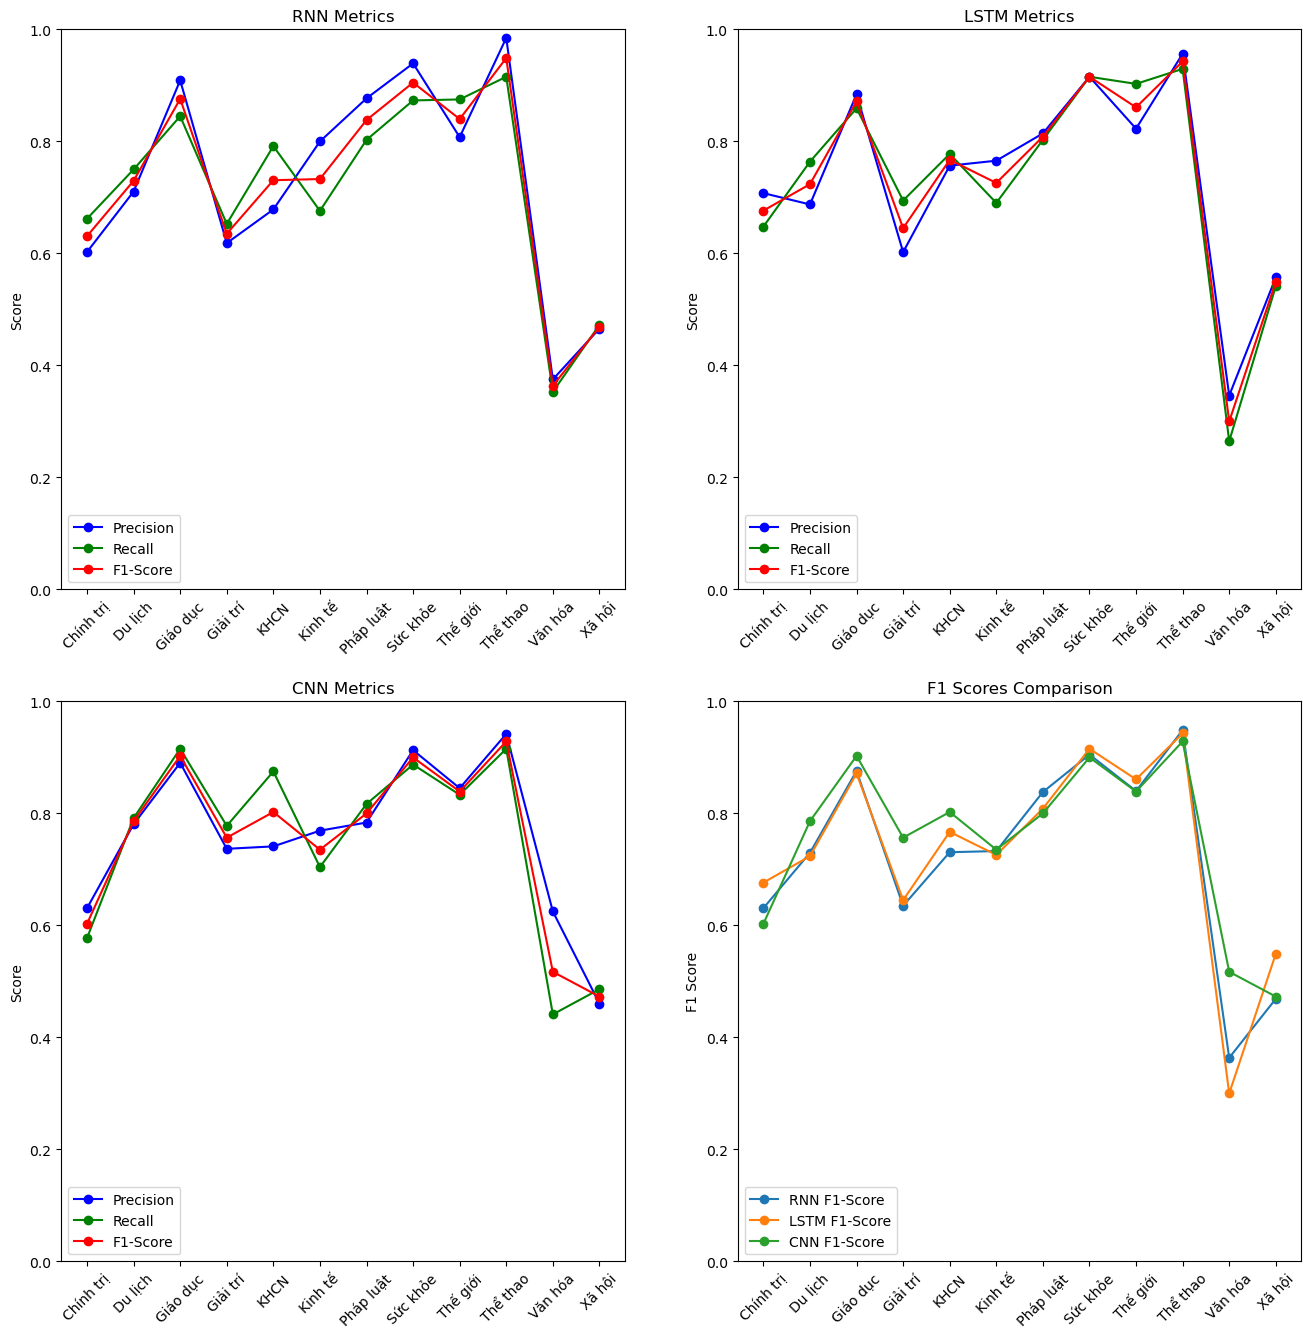

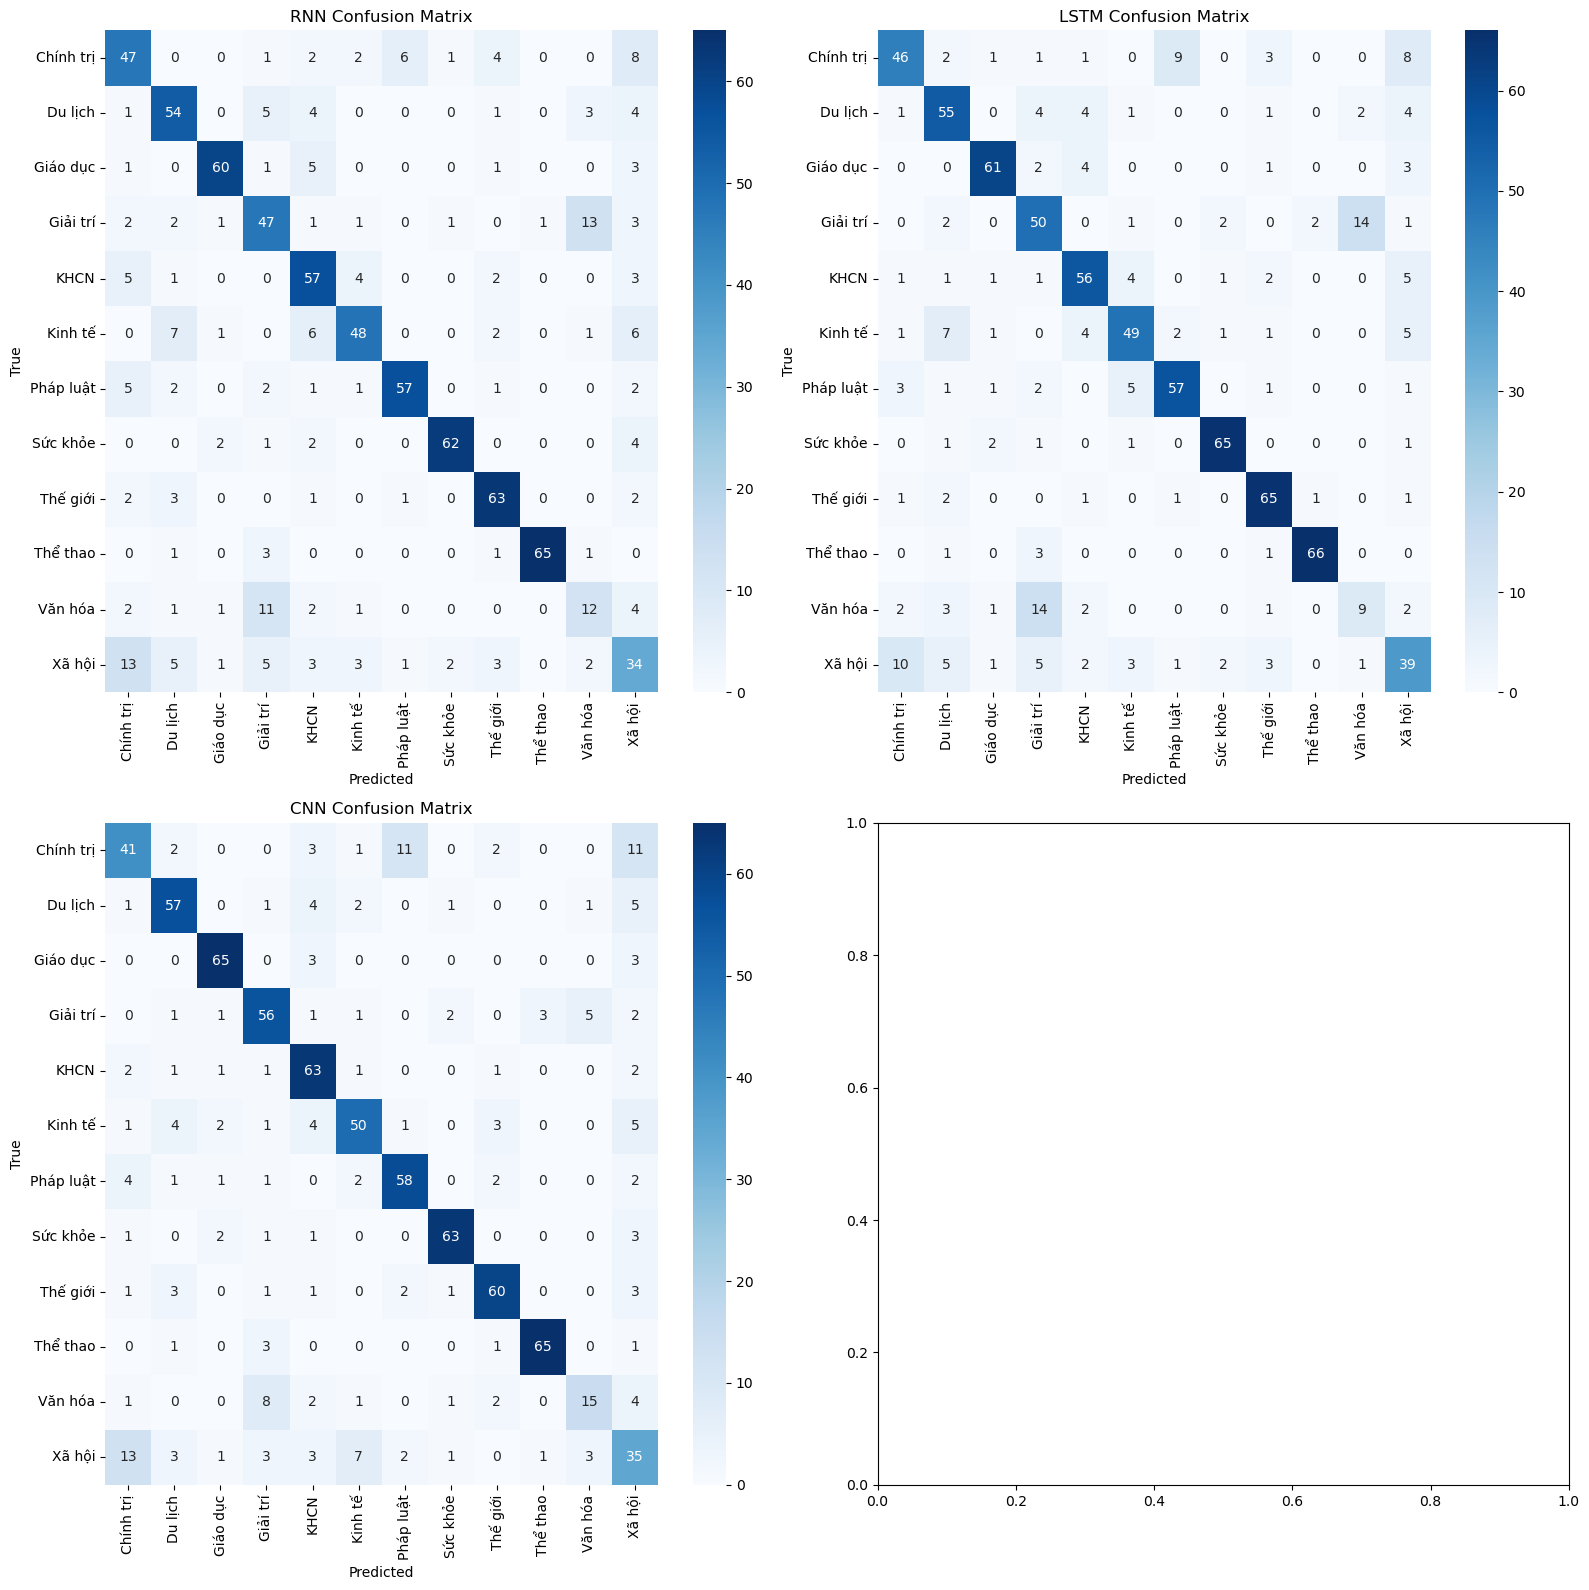

In [35]:
# Hình vẽ kết quả của mô hình sau khi train
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16))

# Lưu trữ F1 scores của các mô hình
model_f1_scores = {}

for i, (name, model) in enumerate(deep_models.items()):
    print(f"Training {name} model...")
    y_test, y_pred = train_and_evaluate(model, train_loader, test_loader, num_epochs=10,
                                        criterion=criterion, optimizer_fn=optimizer_fn, scheduler_fn=scheduler_fn)
    y_test = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(y_pred)

    # Tạo báo cáo phân loại
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'

    # Tạo dữ liệu để vẽ biểu đồ
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]
    model_f1_scores[name] = f1_scores

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}\n')

    # Vẽ biểu đồ đường
    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

# Vẽ F1 scores của cả 3 mô hình lên subplot thứ 4
for name, f1_scores in model_f1_scores.items():
    axs[1, 1].plot(categories, f1_scores, marker='o', label=f'{name} F1-Score')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title('F1 Scores Comparison')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [36]:
# In nhãn dự đoán và nhãn thực tế
print("Văn bản đầu vào: ", texts_test[0])
print("Nhãn dự đoán: ", y_pred[0])
print("Nhãn thực tế: ", y_test[0])

Văn bản đầu vào:  thủ tướng phạm minh chính phu nhân đường thăm hàn quốc nhận lời mời thủ tướng hàn quốc han duck soo phu nhân sáng 306 thủ tướng phạm minh chính phu nhân đoàn đại biểu cấp cao việt nam rời hà nội đường thăm chính thức hàn quốc ngày 306 37 thủ tướng phạm minh chính phu nhân đường thăm hàn quốc ảnh nhật bắc tháp tùng thủ tướng phạm minh chính bộ trưởng bộ ngoại giao bùi thanh sơn bộ trưởng bộ kế hoạch đầu tư nguyễn chí dũng bộ trưởng chủ nhiệm văn phòng chính phủ trần văn sơn bộ trưởng bộ tài chính hồ đức phớc bộ trưởng bộ nông nghiệp phát triển nông thôn lê minh hoan bộ trưởng bộ lao động thương binh xã hội đào ngọc dung bộ trưởng bộ công thương nguyễn hồng diên bộ trưởng bộ khoa học công nghệ huỳnh thành đạt bộ trưởng bộ tài nguyên môi trường đặng quốc khánh bộ trưởng bộ văn hóa thể thao du lịch nguyễn văn hùng tham gia đoàn còn thượng tướng lê huy vịnh thứ trưởng bộ quốc phòng đại sứ đặc mệnh toàn quyền việt nam hàn quốc vũ hồ lãnh đạo một số bộ ngành địa phương phó đ

Save trained model

In [44]:
import os
os.makedirs('models', exist_ok=True)
# Lưu mô hình
for name, model in deep_models.items():
    torch.save(model.state_dict(), f'models/{name}_model.bin')

#### Homework

In [39]:
le.classes_

array(['Chính trị', 'Du lịch', 'Giáo dục', 'Giải trí', 'KHCN', 'Kinh tế',
       'Pháp luật', 'Sức khỏe', 'Thế giới', 'Thể thao', 'Văn hóa',
       'Xã hội'], dtype='<U9')

In [46]:
example_text = "Đây là phản ứng hôm 13/7 của ông Peskov, sau khi người đứng đầu Tổng cục Tình báo Quốc phòng Ukraine (GUR) Kirill Budanov hé lộ lời đe dọa trong một cuộc phỏng vấn gần đây. Ông Peskov nhấn mạnh, Moscow nhận thức được các mối đe dọa, và có các biện pháp bảo vệ phù hợp.\n\"Tất cả các mối đe dọa từ chính quyền Kiev đã rõ ràng. Do đó, an ninh của Tổng thống được thiết lập ở mức phù hợp\", ông Peskov chia sẻ với hãng truyền thông Life của Nga.\n[Tổng thống Nga Vladimir Putin. Ảnh: Sputnik]\nTrước đó, hôm 12/7, trong cuộc phỏng vấn với hãng tin NV của Ukraine, ông Budanov, người bị Moscow đưa vào danh sách các cá nhân cực đoan, đã tiết lộ nỗ lực của Kiev nhắm mục tiêu vào ông Putin. Theo quan chức Ukraine, Kiev đã nhiều lần nhắm mục tiêu vào nhà lãnh đạo Nga, nhưng không cung cấp thêm thông tin chi tiết.\n“Những nỗ lực nhắm mục tiêu vào ông Putin đã diễn ra, nhưng cho đến nay vẫn không thành công\", ông Budanov cho biết.\nTrong giai đoạn bùng nổ xung đột Nga – Ukraine, một số hãng truyền thông phương Tây từng đưa tin về việc ông Putin trở thành mục tiêu bị tấn công. Điển hình, hồi tháng 9/2022, tờ The Sun của Anh cho biết một vụ nổ đã xảy ra gần đoàn xe của Tổng Thống Nga. Trong khi đó, vào đầu năm 2023, một số cơ quan truyền thông Đức cho biết, Tổng thống Putin đã bị máy bay không người lái (UAV) tấn công bất thành. Tuy nhiên, vào thời điểm đó, Điện Kremlin đã bác bỏ thông tin này."
example_text = preprocess_text(example_text)[0]
example_text = encode_texts([example_text], tokenizer, embeder)
example_text.shape

Chuyển từ thành vector:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 128, 768])

In [47]:
# predict
model = deep_models['CNN']
model.eval()
with torch.no_grad():
    example_text = example_text.to(device)
    outputs = model(example_text)
    _, preds = torch.max(outputs, 1)

le.inverse_transform(preds.cpu().numpy())[0]

'Thế giới'

Load data

In [41]:
# read a data file
PATH_TO_NEWS_FILE = './data/test_news_no_cat.json'
with open(PATH_TO_NEWS_FILE, 'r', encoding='utf-8') as file:
    news_data = json.load(file)

news_data[0]

{'url': None,
 'title': 'Nhiều tháng đóng bảo hiểm xã hội bỗng "biến mất" trên ứng dụng quản lý',
 'description': 'Một số người lao động truy cập vào tài khoản bảo hiểm xã hội (BHXH) số - VssID thì thấy quá trình tham gia của mình "biến mất" nhiều tháng.',
 'content': 'Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. Bắt đầu từ tháng 11/2023 đến nay, chị Phương tham gia BHXH bắt buộc tại công ty. Tuy nhiên, khi truy cập tài khoản VssID, chị Phương không thấy quá trình tham gia BHXH của mình được cập nhật.\nCũng giống Phương, chị Thanh Tuyền tham gia BHXH từ tháng 7/2017 đến nay, trải qua 3 công ty và có 2 giai đoạn tạm ngừng tham gia. Tuy nhiên, khi truy cập tài khoản VssID, chị Tuyền phát hiện quá trình tham gia của mình thiếu mất giai đoạn làm việc ở công ty thứ 2, kéo dài từ tháng 9/2021 đến tháng 3/2022.\nMới đây, anh Tuấn (làm việc tại một công ty dịch vụ công ích ở TPHCM) truy cập tài khoản VssID cũng thấy thiếu quá trình đóng BHXH từ tháng 8/2007 đến tháng 4/2009. Trong

In [48]:
# get example labels
PATH_TO_NEWS_LABELS = './data/test_news_predicted.json'
with open(PATH_TO_NEWS_LABELS, 'r', encoding='utf-8') as file:
    news_data_labels = json.load(file)

news_data_labels[0]

{'url': None,
 'title': 'Nhiều tháng đóng bảo hiểm xã hội bỗng "biến mất" trên ứng dụng quản lý',
 'description': 'Một số người lao động truy cập vào tài khoản bảo hiểm xã hội (BHXH) số - VssID thì thấy quá trình tham gia của mình "biến mất" nhiều tháng.',
 'content': 'Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. Bắt đầu từ tháng 11/2023 đến nay, chị Phương tham gia BHXH bắt buộc tại công ty. Tuy nhiên, khi truy cập tài khoản VssID, chị Phương không thấy quá trình tham gia BHXH của mình được cập nhật.\nCũng giống Phương, chị Thanh Tuyền tham gia BHXH từ tháng 7/2017 đến nay, trải qua 3 công ty và có 2 giai đoạn tạm ngừng tham gia. Tuy nhiên, khi truy cập tài khoản VssID, chị Tuyền phát hiện quá trình tham gia của mình thiếu mất giai đoạn làm việc ở công ty thứ 2, kéo dài từ tháng 9/2021 đến tháng 3/2022.\nMới đây, anh Tuấn (làm việc tại một công ty dịch vụ công ích ở TPHCM) truy cập tài khoản VssID cũng thấy thiếu quá trình đóng BHXH từ tháng 8/2007 đến tháng 4/2009. Trong

Load labels

In [49]:
news_labels = []
for news in news_data_labels:
    news_labels.append(news['metadata']['cat'])

news_labels[:5]

['Xã hội', 'Du lịch', 'Sức khỏe', 'Văn hóa', 'Pháp luật']

Load obsereved data (text to predict)

In [55]:
news_texts = []
for news in news_data:
    text = news.get('title', '') + ' ' + news.get('content', '')
    news_texts.append(text)

In [56]:
tqdm_iter = tqdm(news_texts, desc="Processing texts")
processed_news_texts = []
sum_stop_words_percents = 0

for i, text in enumerate(tqdm_iter):
    processed_text, stop_words_percent = preprocess_text(text)
    processed_news_texts.append(processed_text)
    sum_stop_words_percents += stop_words_percent
    avg_stop_words_percent = sum_stop_words_percents / (i+1)
    tqdm_iter.set_postfix({"avg_stop_words_percent": f"{avg_stop_words_percent:.2f}%"})

Processing texts:   0%|          | 0/3755 [00:00<?, ?it/s]

Encode observed data to tensor

In [57]:
news_texts_encoded = encode_texts(processed_news_texts, tokenizer, embeder)
news_texts_encoded.shape

Chuyển từ thành vector:   0%|          | 0/3755 [00:00<?, ?it/s]

torch.Size([3755, 128, 768])

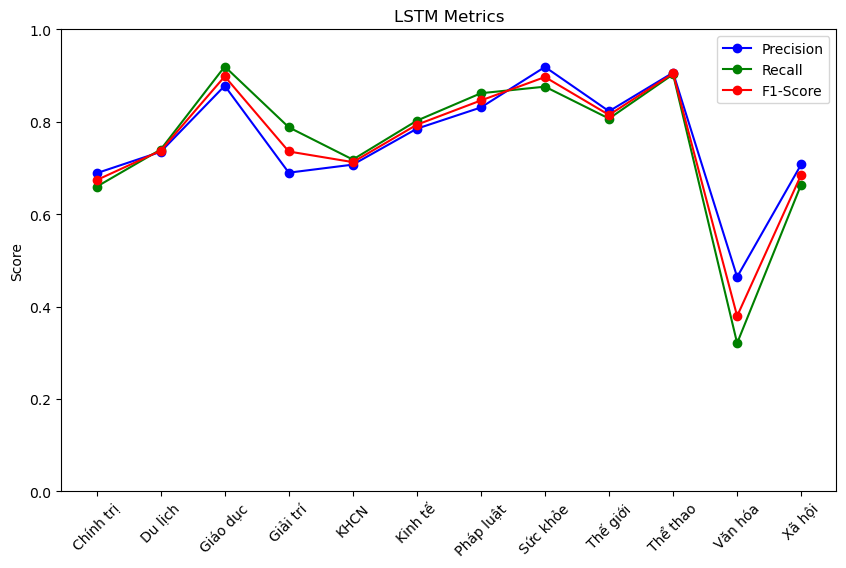

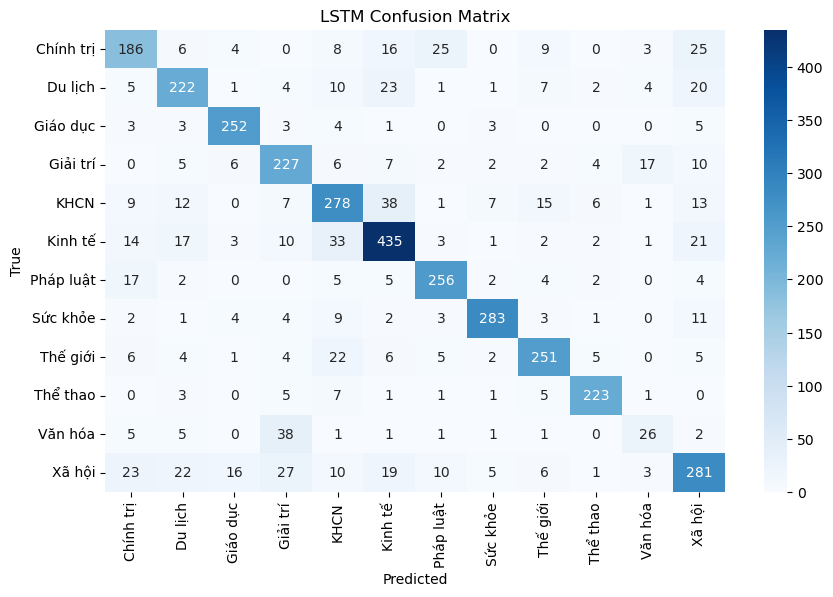

In [63]:
# predict and evaluate
news_labels_enc = le.transform(news_labels)
test_dataset = TextDataset(news_texts_encoded, news_labels_enc)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = deep_models['LSTM']
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_test = le.inverse_transform(all_labels)
y_pred = le.inverse_transform(all_preds)

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Vẽ biểu đồ và confusion matrix
categories = list(report.keys())[:-3]
precisions = [report[cat]['precision'] for cat in categories]
recalls = [report[cat]['recall'] for cat in categories]
f1_scores = [report[cat]['f1-score'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.plot(categories, precisions, marker='o', label='Precision', color='blue')
plt.plot(categories, recalls, marker='o', label='Recall', color='green')
plt.plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
plt.ylim(0, 1)
plt.title('LSTM Metrics')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [72]:
# Lưu kết quả dự đoán vào news_data
for i, news in enumerate(news_data):
    news['metadata']['cat'] = y_pred[i]

# Lưu kết quả dự đoán vào file
PATH_TO_NEWS_PREDICTED = './data/my_news_predicted.json'
with open(PATH_TO_NEWS_PREDICTED, 'w', encoding='utf-8') as file:
    json.dump(news_data, file, ensure_ascii=False, indent=4)

In [78]:
matched = 0
for i, news in enumerate(news_data[:10]):
    print(f"Title: {news['title']}")
    print(f"Content: {news['content'][:100]}...")
    print(f"Pred: {news['metadata']['cat']}")
    print(f"True: {news_labels[i]}")
    print("---")
    if news['metadata']['cat'] == news_labels[i]:
        matched += 1
print(f"Matched: {matched}/{len(news_data[:10])}")

Title: Nhiều tháng đóng bảo hiểm xã hội bỗng "biến mất" trên ứng dụng quản lý
Content: Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. Bắt đầu từ tháng 11/2023 đến nay, chị Phươ...
Pred: Xã hội
True: Xã hội
---
Title: Nhà hàng đậm chất Việt vào danh sách Michelin
Content: Luk Lak, nhà hàng món Việt nằm ở quận Hoàn Kiếm, là cái tên mới được Michelin Guide bổ sung vào danh...
Pred: Du lịch
True: Du lịch
---
Title: Phẫu thuật '2 trong 1' chữa nghẹt mũi kéo dài
Content: Ông Tân điều trị bệnh gần hai năm không cải thiện, ảnh hưởng cuộc sống, đến Bệnh viện Đa khoa Tâm An...
Pred: Sức khỏe
True: Sức khỏe
---
Title: Có gì trong bộ phim ngốn tới 5.000 tỷ đồng sắp ra rạp Việt?
Content: Ra mắt vào năm 1996, Twister (Lốc xoáy tử thần) được coi là một trong những bom tấn hay nhất thế kỷ ...
Pred: Giải trí
True: Văn hóa
---
Title: Công an truy tìm kẻ phá hoại hàng loạt cây sầu riêng sắp thu hoạch ở Đắk Lắk
Content: Trao đổi với PV sáng 17/7, một lãnh đạo UBND xã Ea Nam cho biết, hiện chưa 